## Graph Neural Networks

We now use Tensorflow to classify nodes in a graph using Graph Convolution Networks.

First, install gcn on your machine using the 'python setup.py install' command.

# Exercise for semisupervised classification on citation networks

In [1]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf
from gcn.utils import *
from gcn.models import Model,MLP
from gcn.layers import *

In [2]:
# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'
flags.DEFINE_string('model', 'gcn', 'Model string.')  # 'gcn', 'gcn_cheby', 'dense'
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
#flags.DEFINE_float('learning_rate', 0.1, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
#flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
#flags.DEFINE_float('weight_decay', 0, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 100, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

In [3]:
def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking."""
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

#--------------- Your code here --------------#
# masked_mean_square_error(preds,labels,mask)


#--------------------------------------------#

def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

In [19]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
#        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                                 self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

In [5]:
def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)
#    adj_square = np.power(adj,2).tocoo()
#    return sparse_to_tuple(adj)


In [32]:
# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset)

# Some preprocessing
features = preprocess_features(features)
if FLAGS.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

In [7]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95399 train_acc= 0.07143 val_loss= 1.95070 val_acc= 0.20600 time= 0.08159
Epoch: 0002 train_loss= 1.94801 train_acc= 0.29286 val_loss= 1.94716 val_acc= 0.37000 time= 0.01924
Epoch: 0003 train_loss= 1.94218 train_acc= 0.48571 val_loss= 1.94333 val_acc= 0.47000 time= 0.01835
Epoch: 0004 train_loss= 1.93654 train_acc= 0.56429 val_loss= 1.93922 val_acc= 0.50400 time= 0.01496
Epoch: 0005 train_loss= 1.92665 train_acc= 0.66429 val_loss= 1.93517 val_acc= 0.50400 time= 0.01520
Epoch: 0006 train_loss= 1.92017 train_acc= 0.70000 val_loss= 1.93110 val_acc= 0.51400 time= 0.01453
Epoch: 0007 train_loss= 1.91050 train_acc= 0.71429 val_loss= 1.92704 val_acc= 0.52000 time= 0.01534
Epoch: 0008 train_loss= 1.89941 train_acc= 0.71429 val_loss= 1.92310 val_acc= 0.51600 time= 0.01534
Epoch: 0009 train_loss= 1.89015 train_acc= 0.75714 val_loss= 1.91920 val_acc= 0.52000 time= 0.01520
Epoch: 0010 train_loss= 1.88369 train_acc= 0.67143 val_loss= 1.91527 val_acc= 0.52000 time= 0.01484


Epoch: 0086 train_loss= 0.94996 train_acc= 0.93571 val_loss= 1.35739 val_acc= 0.77800 time= 0.02371
Epoch: 0087 train_loss= 0.97249 train_acc= 0.92857 val_loss= 1.35100 val_acc= 0.78000 time= 0.02368
Epoch: 0088 train_loss= 0.94913 train_acc= 0.93571 val_loss= 1.34459 val_acc= 0.78000 time= 0.02430
Epoch: 0089 train_loss= 0.97455 train_acc= 0.91429 val_loss= 1.33826 val_acc= 0.78000 time= 0.02321
Epoch: 0090 train_loss= 0.97957 train_acc= 0.91429 val_loss= 1.33204 val_acc= 0.78000 time= 0.02504
Epoch: 0091 train_loss= 0.92480 train_acc= 0.95000 val_loss= 1.32596 val_acc= 0.78000 time= 0.02576
Epoch: 0092 train_loss= 0.95817 train_acc= 0.92143 val_loss= 1.32011 val_acc= 0.78000 time= 0.02571
Epoch: 0093 train_loss= 0.89500 train_acc= 0.95000 val_loss= 1.31456 val_acc= 0.77800 time= 0.02202
Epoch: 0094 train_loss= 0.86474 train_acc= 0.92857 val_loss= 1.30937 val_acc= 0.77800 time= 0.02436
Epoch: 0095 train_loss= 0.90715 train_acc= 0.96429 val_loss= 1.30445 val_acc= 0.78000 time= 0.02505


Epoch: 0169 train_loss= 0.65012 train_acc= 0.96429 val_loss= 1.10007 val_acc= 0.78200 time= 0.02340
Epoch: 0170 train_loss= 0.66773 train_acc= 0.95000 val_loss= 1.09972 val_acc= 0.78200 time= 0.02697
Epoch: 0171 train_loss= 0.72109 train_acc= 0.92857 val_loss= 1.09840 val_acc= 0.78200 time= 0.02478
Epoch: 0172 train_loss= 0.67563 train_acc= 0.95714 val_loss= 1.09644 val_acc= 0.78200 time= 0.01820
Epoch: 0173 train_loss= 0.64704 train_acc= 0.97143 val_loss= 1.09398 val_acc= 0.78200 time= 0.01946
Epoch: 0174 train_loss= 0.58342 train_acc= 0.98571 val_loss= 1.09138 val_acc= 0.77800 time= 0.01823
Epoch: 0175 train_loss= 0.67515 train_acc= 0.94286 val_loss= 1.08887 val_acc= 0.77400 time= 0.02140
Epoch: 0176 train_loss= 0.68394 train_acc= 0.93571 val_loss= 1.08582 val_acc= 0.77800 time= 0.01827
Epoch: 0177 train_loss= 0.70085 train_acc= 0.94286 val_loss= 1.08304 val_acc= 0.77800 time= 0.01919
Epoch: 0178 train_loss= 0.60540 train_acc= 0.98571 val_loss= 1.08044 val_acc= 0.77800 time= 0.01998


In [8]:
# Testing
test_cost, test_acc, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))

Test set results: cost= 1.01263 accuracy= 0.81400 time= 0.01245


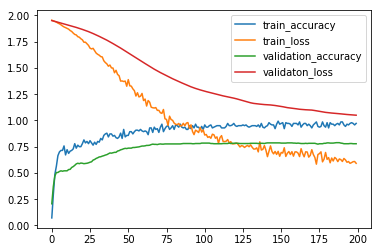

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.show()

# 1. With no weight decay / dropout  (covered in class)

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **without weight decay and without dropout**.

In [15]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += tf.nn.l2_loss(var) # no decay

        # Cross entropy error
#        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                                 self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=False,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=False,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

In [16]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    # feed_dict.update({placeholders['dropout']: FLAGS.dropout}) no dropout

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95303 train_acc= 0.16429 val_loss= 1.94921 val_acc= 0.24200 time= 0.03408
Epoch: 0002 train_loss= 1.94399 train_acc= 0.46429 val_loss= 1.94427 val_acc= 0.30200 time= 0.02369
Epoch: 0003 train_loss= 1.93449 train_acc= 0.59286 val_loss= 1.93925 val_acc= 0.31000 time= 0.03224
Epoch: 0004 train_loss= 1.92463 train_acc= 0.58571 val_loss= 1.93461 val_acc= 0.31200 time= 0.02242
Epoch: 0005 train_loss= 1.91481 train_acc= 0.58571 val_loss= 1.93031 val_acc= 0.32000 time= 0.02378
Epoch: 0006 train_loss= 1.90495 train_acc= 0.60000 val_loss= 1.92624 val_acc= 0.32400 time= 0.02447
Epoch: 0007 train_loss= 1.89495 train_acc= 0.63571 val_loss= 1.92230 val_acc= 0.33200 time= 0.02517
Epoch: 0008 train_loss= 1.88483 train_acc= 0.64286 val_loss= 1.91843 val_acc= 0.34600 time= 0.02136
Epoch: 0009 train_loss= 1.87453 train_acc= 0.67143 val_loss= 1.91460 val_acc= 0.36200 time= 0.02107
Epoch: 0010 train_loss= 1.86405 train_acc= 0.68571 val_loss= 1.91077 val_acc= 0.38000 time= 0.02413


Epoch: 0088 train_loss= 0.85161 train_acc= 0.98571 val_loss= 1.37371 val_acc= 0.78200 time= 0.02266
Epoch: 0089 train_loss= 0.84374 train_acc= 0.98571 val_loss= 1.36747 val_acc= 0.78400 time= 0.02188
Epoch: 0090 train_loss= 0.83606 train_acc= 0.98571 val_loss= 1.36159 val_acc= 0.78400 time= 0.01845
Epoch: 0091 train_loss= 0.82854 train_acc= 0.98571 val_loss= 1.35554 val_acc= 0.78400 time= 0.01786
Epoch: 0092 train_loss= 0.82119 train_acc= 0.98571 val_loss= 1.34951 val_acc= 0.78200 time= 0.01996
Epoch: 0093 train_loss= 0.81401 train_acc= 0.98571 val_loss= 1.34388 val_acc= 0.78200 time= 0.01768
Epoch: 0094 train_loss= 0.80699 train_acc= 0.98571 val_loss= 1.33834 val_acc= 0.78200 time= 0.01754
Epoch: 0095 train_loss= 0.80013 train_acc= 0.98571 val_loss= 1.33276 val_acc= 0.78400 time= 0.01769
Epoch: 0096 train_loss= 0.79339 train_acc= 0.98571 val_loss= 1.32712 val_acc= 0.78400 time= 0.01804
Epoch: 0097 train_loss= 0.78682 train_acc= 0.98571 val_loss= 1.32161 val_acc= 0.78400 time= 0.01754


Epoch: 0175 train_loss= 0.51431 train_acc= 1.00000 val_loss= 1.08630 val_acc= 0.79200 time= 0.01792
Epoch: 0176 train_loss= 0.51240 train_acc= 1.00000 val_loss= 1.08468 val_acc= 0.79200 time= 0.02193
Epoch: 0177 train_loss= 0.51050 train_acc= 1.00000 val_loss= 1.08298 val_acc= 0.79200 time= 0.01940
Epoch: 0178 train_loss= 0.50862 train_acc= 1.00000 val_loss= 1.08109 val_acc= 0.79200 time= 0.01772
Epoch: 0179 train_loss= 0.50676 train_acc= 1.00000 val_loss= 1.07923 val_acc= 0.79200 time= 0.01808
Epoch: 0180 train_loss= 0.50492 train_acc= 1.00000 val_loss= 1.07783 val_acc= 0.79200 time= 0.01767
Epoch: 0181 train_loss= 0.50310 train_acc= 1.00000 val_loss= 1.07651 val_acc= 0.79200 time= 0.01792
Epoch: 0182 train_loss= 0.50129 train_acc= 1.00000 val_loss= 1.07499 val_acc= 0.79200 time= 0.01724
Epoch: 0183 train_loss= 0.49951 train_acc= 1.00000 val_loss= 1.07329 val_acc= 0.79200 time= 0.01750
Epoch: 0184 train_loss= 0.49774 train_acc= 1.00000 val_loss= 1.07171 val_acc= 0.79200 time= 0.01838


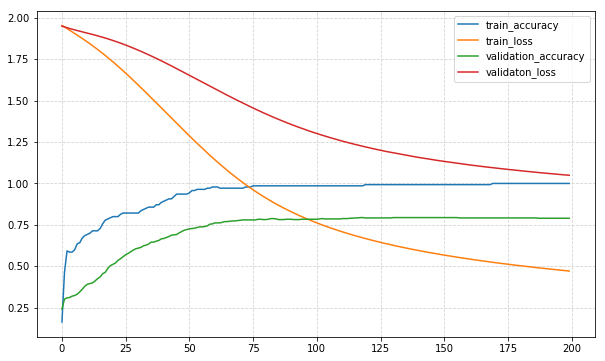

In [17]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

# 2. Change it to $A^2$ (covered in class)

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **after changing the adjacency matrix to $A^2$ **.

In [31]:
def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_square = normalize_adj(np.power(adj, 2).tocoo())
    return sparse_to_tuple(adj_square)
#    adj_square = np.power(adj,2).tocoo()
#    return sparse_to_tuple(adj)


In [33]:
# Remember to re-run GCN model again!!!
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95373 train_acc= 0.08571 val_loss= 1.94843 val_acc= 0.46000 time= 0.08060
Epoch: 0002 train_loss= 1.94778 train_acc= 0.44286 val_loss= 1.94346 val_acc= 0.58600 time= 0.04093
Epoch: 0003 train_loss= 1.94216 train_acc= 0.57857 val_loss= 1.93733 val_acc= 0.63800 time= 0.04120
Epoch: 0004 train_loss= 1.93582 train_acc= 0.59286 val_loss= 1.93113 val_acc= 0.63000 time= 0.03609
Epoch: 0005 train_loss= 1.93021 train_acc= 0.59286 val_loss= 1.92561 val_acc= 0.62800 time= 0.03624
Epoch: 0006 train_loss= 1.92354 train_acc= 0.55714 val_loss= 1.92053 val_acc= 0.64400 time= 0.03796
Epoch: 0007 train_loss= 1.91747 train_acc= 0.64286 val_loss= 1.91546 val_acc= 0.64800 time= 0.04131
Epoch: 0008 train_loss= 1.91011 train_acc= 0.63571 val_loss= 1.91040 val_acc= 0.66400 time= 0.04421
Epoch: 0009 train_loss= 1.90653 train_acc= 0.65714 val_loss= 1.90525 val_acc= 0.66800 time= 0.03519
Epoch: 0010 train_loss= 1.89866 train_acc= 0.69286 val_loss= 1.90010 val_acc= 0.68000 time= 0.03295


Epoch: 0087 train_loss= 1.09770 train_acc= 0.89286 val_loss= 1.39916 val_acc= 0.77400 time= 0.03739
Epoch: 0088 train_loss= 1.09807 train_acc= 0.87857 val_loss= 1.39355 val_acc= 0.77200 time= 0.04207
Epoch: 0089 train_loss= 1.09069 train_acc= 0.88571 val_loss= 1.38773 val_acc= 0.77000 time= 0.03266
Epoch: 0090 train_loss= 1.11794 train_acc= 0.87857 val_loss= 1.38209 val_acc= 0.77000 time= 0.03679
Epoch: 0091 train_loss= 1.07024 train_acc= 0.91429 val_loss= 1.37574 val_acc= 0.77400 time= 0.03526
Epoch: 0092 train_loss= 1.07378 train_acc= 0.87857 val_loss= 1.36926 val_acc= 0.77800 time= 0.03955
Epoch: 0093 train_loss= 1.06124 train_acc= 0.89286 val_loss= 1.36310 val_acc= 0.78000 time= 0.04914
Epoch: 0094 train_loss= 1.06788 train_acc= 0.88571 val_loss= 1.35728 val_acc= 0.78000 time= 0.04578
Epoch: 0095 train_loss= 1.05065 train_acc= 0.89286 val_loss= 1.35175 val_acc= 0.78000 time= 0.04697
Epoch: 0096 train_loss= 1.07844 train_acc= 0.87143 val_loss= 1.34675 val_acc= 0.78000 time= 0.04270


Epoch: 0170 train_loss= 0.76522 train_acc= 0.91429 val_loss= 1.16035 val_acc= 0.78400 time= 0.03273
Epoch: 0171 train_loss= 0.74506 train_acc= 0.93571 val_loss= 1.15760 val_acc= 0.78400 time= 0.03833
Epoch: 0172 train_loss= 0.76949 train_acc= 0.92857 val_loss= 1.15484 val_acc= 0.78400 time= 0.03208
Epoch: 0173 train_loss= 0.79483 train_acc= 0.90000 val_loss= 1.15323 val_acc= 0.78400 time= 0.03067
Epoch: 0174 train_loss= 0.78319 train_acc= 0.90714 val_loss= 1.15172 val_acc= 0.78600 time= 0.03115
Epoch: 0175 train_loss= 0.79578 train_acc= 0.92143 val_loss= 1.15094 val_acc= 0.78400 time= 0.03079
Epoch: 0176 train_loss= 0.78273 train_acc= 0.92143 val_loss= 1.15019 val_acc= 0.78400 time= 0.03099
Epoch: 0177 train_loss= 0.78539 train_acc= 0.90000 val_loss= 1.14999 val_acc= 0.78400 time= 0.03949
Epoch: 0178 train_loss= 0.77605 train_acc= 0.92143 val_loss= 1.14974 val_acc= 0.78600 time= 0.04076
Epoch: 0179 train_loss= 0.79922 train_acc= 0.92857 val_loss= 1.14996 val_acc= 0.78400 time= 0.03251


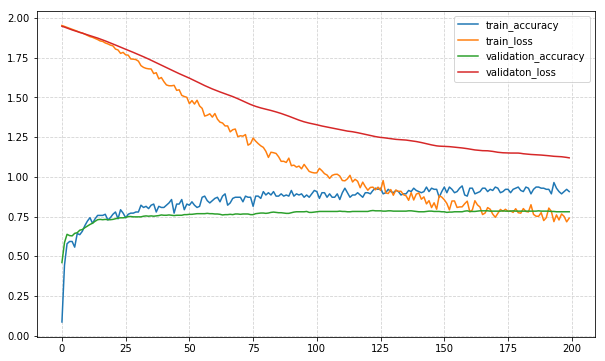

In [34]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

# 3. Change to the $L_2$ loss

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **with the loss function being $L_2$ loss**.

In [10]:
#--------------- Your code here --------------#





#--------------------------------------------#

# 4. Change the input graph/label

Now, create the input graphs using a Stochastic Block Model. The number of nodes should be 500, and then feed the true labels using $20%$ of the nodes. The degree of a node must be used as the feature.
Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps for this input graph.

In [11]:
#--------------- Your code here --------------#





#--------------------------------------------#